In [ ]:
!pip install -qU \
    datasets==2.17.1 \
    "semantic-router[processing]==0.0.24" \
    tiktoken==0.6.0 \
    langchain-core==0.1.26 \
    langchain==0.1.9

In [1]:
text = """
# Guides
## Data
### Manage RAG documents

In Retrieval Augmented Generation (RAG) use cases, it is best practice to chunk
large documents into smaller segments, embed each chunk separately, and then
store each embedded chunk as a distinct record in Pinecone. This page shows you
how to model, store, and manage such records in serverless indexes.

#### Use ID prefixes to reference parent documents

When you have multiple records representing chunks of a single document, use a
common ID prefix to reference the document.

##### ℹ️ Note

You can use any prefix pattern you like, but make sure you use a consistent
prefix pattern for all child records of a document. For example, doc1#chunk1,
doc1_chunk1, doc1_chunk1, doc1___chunk1, doc1:chunk1, and doc1chunk1 are all
valid prefixes for the first chunk of doc1. Prefixes can also be multi-level.
For example, doc1#v1#chunk1 and doc1#v2#chunk1 could represent different
versions of the first chunk of doc1.


```python
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="YOUR_API_KEY")

pc.create_index(
  name="serverless-index",
  dimension=8,
  metric="cosine",
  spec=ServerlessSpec(
    cloud="aws",
    region="us-west-2"
  )
)

index = pc.Index("serverless-index")

index.upsert(
  vectors=[
    {"id": "doc1#chunk1", "values": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]},
    {"id": "doc1#chunk2", "values": [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]},
    {"id": "doc1#chunk3", "values": [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]},
    {"id": "doc1#chunk4", "values": [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]}
  ],
  namespace="ns1"
)
```

#### List all record IDs for a parent document

When all records related to a document use a common ID prefix, you can use the
`list` operation, with the `namespace` and `prefix` parameters, to fetch the
IDs of the records.

```curl
# The `GET` request below uses the unique endpoint for an index.
# See https://docs.pinecone.io/docs/get-index-endpoint for details.
PINECONE_API_KEY="YOUR_API_KEY"
INDEX_HOST="INDEX_HOST"

curl -X GET "https://$INDEX_HOST/vectors/list?namespace=ns1&prefix=doc1#" \
  -H "Api-Key: $PINECONE_API_KEY"

# Response:
# {
#   "vectors": [
#     { "id": "doc1#chunk1" },
#     { "id": "doc1#chunk2" },
#     { "id": "doc1#chunk3" },
#     { "id": "doc1#chunk4" },
    ...
#   ],
#   "pagination": {
#     "next": "c2Vjb25kY2FsbA=="
#   },
#   "namespace": "ns1",
#   "usage": {
#     "readUnits": 1
#   }
# }
```

When there are additional IDs to return, the response includes a
`pagination_token` that you can use to get the next batch of IDs. For more
details, see Paginate through list results

With the record IDs, you can then use the fetch operation to fetch the content
of the records.

#### Delete all records for a parent document

To delete all records representing chunks of a single document, first list the
record IDs based on their common ID prefix:

##### ℹ️ Note

The `list` operation is supported only for serverless indexes and only via the
REST API.

```curl
# The `GET` request below uses the unique endpoint for an index.
# See https://docs.pinecone.io/docs/get-index-endpoint for details.
PINECONE_API_KEY="YOUR_API_KEY"
INDEX_HOST="INDEX_HOST"

curl -X GET "https://$INDEX_HOST/vectors/list?namespace=ns1&prefix=doc1#" \
  -H "Api-Key: $PINECONE_API_KEY"

# Response:
# {
#   "vectors": [
#     { "id": "doc1#chunk1" },
#     { "id": "doc1#chunk2" },
#     { "id": "doc1#chunk3" },
#     { "id": "doc1#chunk4" },
    ...
#   ],
#   "pagination": {
#     "next": "c2Vjb25kY2FsbA=="
#   },
#   "namespace": "ns1",
#   "usage": {
#     "readUnits": 1
#   }
# }
```

Then delete the records by ID:

```curl
curl -X POST "https://$INDEX_HOST/vectors/delete" \
  -H "Api-Key: $PINECONE_API_KEY" \
  -H 'Content-Type: application/json' \
  -d '{
    "ids": [
      "doc1#chunk1", 
      "doc1#chunk2", 
      "doc1#chunk3", 
      "doc1#chunk4"
    ],
    "namespace": "ns1"
  }
'
```

#### Work with multi-level ID prefixes

The examples above are based on a simple ID prefix (doc1#), but it's also
possible to work with more complex, multi-level prefixes.

For example, let's say you use the prefix pattern document#version#chunk to 
differentiate between different versions of a document. If you wanted to delete
all records for one version of a document, you would first list the record IDs
based on the relevant document#version# prefix:

```curl
# The `GET` request below uses the unique endpoint for an index.
# See https://docs.pinecone.io/docs/get-index-endpoint for details.
PINECONE_API_KEY="YOUR_API_KEY"
INDEX_HOST="INDEX_HOST"

curl -X GET "https://$INDEX_HOST/vectors/list?namespace=ns1&prefix=doc1%23v1%23" \
  -H "Api-Key: $PINECONE_API_KEY"

# Response:
# {
#   "vectors": [
#     { "id": "doc1#v1#chunk1" },
#     { "id": "doc1#v1#chunk2" },
#     { "id": "doc1#v1#chunk3" },
#     { "id": "doc1#v1#chunk4" },
    ...
#   ],
#   "pagination": {
#     "next": "c2Vjb25kY2FsbA=="
#   },
#   "namespace": "ns1",
#   "usage": {
#     "readUnits": 1
#   }
# }
```

You'd then delete the records by ID

However, if you wanted to delete all records across all versions of a document,
you would list the record IDs based on the doc1# part of the prefix that is
common to all versions:

```curl
# The `GET` request below uses the unique endpoint for an index.
# See https://docs.pinecone.io/docs/get-index-endpoint for details.
PINECONE_API_KEY="YOUR_API_KEY"
INDEX_HOST="INDEX_HOST"

curl -X GET "https://$INDEX_HOST/vectors/list?namespace=ns1&prefix=doc1%23" \
  -H "Api-Key: $PINECONE_API_KEY"

# Response:
# {
#   "vectors": [
#     { "id": "doc1#v1#chunk1" },
#     { "id": "doc1#v1#chunk2" },
#     { "id": "doc1#v1#chunk3" },
#     { "id": "doc1#v1#chunk4" },
#   ...
#     { "id": "doc1#v2#chunk1" },
#     { "id": "doc1#v2#chunk2" },
#     { "id": "doc1#v2#chunk3" },
#     { "id": "doc1#v2#chunk4" },
#   ...
#   ],
#   "pagination": {
#     "next": "c2Vjb25kY2FsbA=="
#   },
#   "namespace": "ns1",
#   "usage": {
#     "readUnits": 1
#   }
# }
```

You'd then delete the records by ID.

### RAG using pod-based indexes

The `list` operation does not support pod-based indexes. Instead of using ID
prefixes to reference parent documents, use a metadata key-value pair. If you
later need to delete the records, you can pass a metadata filter expression to
the delete operation.
"""

## Chunk by Tokens

In [29]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken

tokenizer = tiktoken.get_encoding("p50k_base")

def tiktoken_len(text: str) -> int:
    tokens = tokenizer.encode(
        text, disallowed_special=()
    )
    return len(tokens)

recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

In [31]:
recursive_splits = recursive_splitter.split_text(text)
recursive_splits

['# Guides\n## Data\n### Manage RAG documents\n\nIn Retrieval Augmented Generation (RAG) use cases, it is best practice to chunk\nlarge documents into smaller segments, embed each chunk separately, and then\nstore each embedded chunk as a distinct record in Pinecone. This page shows you\nhow to model, store, and manage such records in serverless indexes.\n\n#### Use ID prefixes to reference parent documents\n\nWhen you have multiple records representing chunks of a single document, use a\ncommon ID prefix to reference the document.\n\n##### ℹ️ Note\n\nYou can use any prefix pattern you like, but make sure you use a consistent\nprefix pattern for all child records of a document. For example, doc1#chunk1,\ndoc1_chunk1, doc1_chunk1, doc1___chunk1, doc1:chunk1, and doc1chunk1 are all\nvalid prefixes for the first chunk of doc1. Prefixes can also be multi-level.\nFor example, doc1#v1#chunk1 and doc1#v2#chunk1 could represent different\nversions of the first chunk of doc1.\n\n\n```python\nfr

## Chunk by Markdown

In [2]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

In [3]:
headers_to_split_on = [
    ("#", "#"),
    ("##", "##"),
    ("###", "###"),
    ("####", "####"),
    ("#####", "#####"),
    ("######", "######"),
]

md_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on,
)

In [4]:
md_parts = md_splitter.split_text(text)

[Document(page_content='In Retrieval Augmented Generation (RAG) use cases, it is best practice to chunk\nlarge documents into smaller segments, embed each chunk separately, and then\nstore each embedded chunk as a distinct record in Pinecone. This page shows you\nhow to model, store, and manage such records in serverless indexes.', metadata={'#': 'Guides', '##': 'Data', '###': 'Manage RAG documents'}),
 Document(page_content='When you have multiple records representing chunks of a single document, use a\ncommon ID prefix to reference the document.', metadata={'#': 'Guides', '##': 'Data', '###': 'Manage RAG documents', '####': 'Use ID prefixes to reference parent documents'}),
 Document(page_content='You can use any prefix pattern you like, but make sure you use a consistent\nprefix pattern for all child records of a document. For example, doc1#chunk1,\ndoc1_chunk1, doc1_chunk1, doc1___chunk1, doc1:chunk1, and doc1chunk1 are all\nvalid prefixes for the first chunk of doc1. Prefixes can 

In [5]:
def md_chunk(doc, add_prefix: bool = False) -> list[str]:
    # create prefix for each chunk based on metadata headers
    if add_prefix:
        prefix = "\n".join([f"{key} {val}" for key, val in doc.metadata.items()])
        return f"{prefix}\n{doc.page_content}"
    else:
        return doc.page_content

In [32]:
md_splits = []

for part in md_parts:
    chunk = md_chunk(part, add_prefix=True)
    print(chunk)
    print("\n---\n")
    md_splits.append(chunk)

NameError: name 'md_parts' is not defined

## Chunk by Meaning

In [58]:
import os
from getpass import getpass
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass(
    "Enter your OpenAI API key: "
)

encoder = OpenAIEncoder()
encoder.score_threshold = 0.79

splitter = RollingWindowSplitter(
    encoder=encoder,
    min_split_tokens=100,
    max_split_tokens=400,
    window_size=5,  # sentences
    plot_splits=True,
    dynamic_threshold=False,
)

In [59]:
from semantic_router.splitters import utils

sentences = utils.split_to_sentences(text)

2024-02-23 11:20:49 WARNING semantic_router.utils.logger Single document exceeds the maximum token limit of 400. Splitting to sentences before semantically splitting.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 221 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 297 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 267 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 330 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 158 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 266 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Split finalized with 351 tokens due to threshold 0.79.
2024-02-23 11:20:50 INFO semantic_router.utils.logger Final split adde

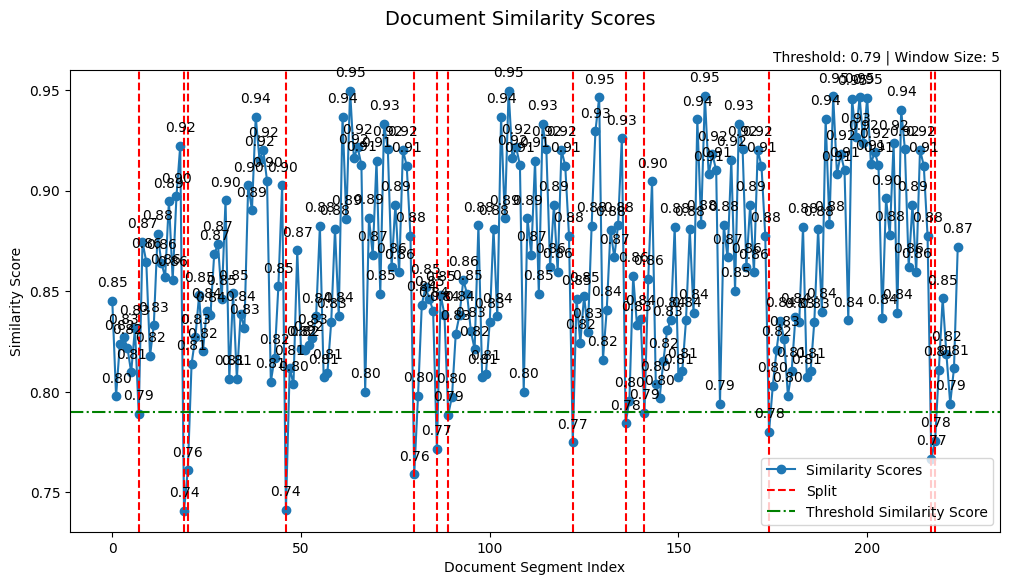

In [60]:
splits = splitter([text])

In [61]:
splitter.print(splits)

Split 1, tokens 221, triggered by: 0.74
# Guides ## Data ### Manage RAG documents In Retrieval Augmented Generation (RAG) use cases, it is best practice to chunk large documents into smaller segments, embed each chunk separately, and then store each embedded chunk as a distinct record in Pinecone. This page shows you how to model, store, and manage such records in serverless indexes. #### Use ID prefixes to reference parent documents When you have multiple records representing chunks of a single document, use a common ID prefix to reference the document. ##### ℹ️ Note You can use any prefix pattern you like, but make sure you use a consistent prefix pattern for all child records of a document. For example, doc1#chunk1, doc1_chunk1, doc1_chunk1, doc1___chunk1, doc1:chunk1, and doc1chunk1 are all valid prefixes for the first chunk of doc1. Prefixes can also be multi-level. For example, doc1#v1#chunk1 and doc1#v2#chunk1 could represent different versions of the first chunk of doc1.
------

In [ ]:
splits